In [23]:
import numpy as np
import matplotlib.pyplot as plt
from math import *
import pandas as pd
import random
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score 
from copy import deepcopy
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.metrics import confusion_matrix,f1_score,accuracy_score,precision_score,recall_score
np.set_printoptions(suppress=True)

In [10]:
def loadData():
    df = pd.read_csv('fashion-mnist_train.csv', index_col=False)
    df = df.sample(frac=1).reset_index(drop=True)   #shuffling the data
    df=df[df['label']<3]
    df=df[df['label']>0]
    data=np.array(df,dtype=np.uint8)
    df1 = pd.read_csv('fashion-mnist_test.csv', index_col=False)
    df1 = df1.sample(frac=1).reset_index(drop=True)   #shuffling the data
    df1=df1[df1['label']<3]
    df1=df1[df1['label']>0]
    data1 = np.array(df1,dtype=np.uint8)
#     data = data[np.logical_not(np.logical_and(data[:,0] == 0, data[:,0] > 2))]
#     data1 = np.delete(data1, np.where((data1[:, 0] == 0 ) & (data1[:, 0] >2))[0], axis=0)
    print("checking",np.where((data1[:, 0] == 0 ) & (data1[:, 0] >2))[0])
    print("size",data.shape)
    xTrain=data[:,1:]
    yTrain=data[:,:1]
    xTest=data1[:,1:]
    yTest=data1[:,:1]
    
    print(xTrain.shape)
    
    #binarising the image pixels to 0 and 255
    xTrain[xTrain<128] = 0
    xTrain[xTrain>=128] = 255
    xTest[xTest<128] = 0
    xTest[xTest>=128] = 255 
    print("size",xTest.shape,yTest.shape)
    return xTrain,yTrain,xTest,yTest

In [3]:
def predict(pixels,meanTrouser,meanPullover,stdTrouser,stdPullover,probabilityTrouser,probabilityPullover):
    
    #calculating probability for trousers
#     print("pixelssss",pixels.shape)
    num = np.exp((-1/2)*(((pixels-meanTrouser)/stdTrouser)**2))
    den = np.sqrt(2 * np.pi)*(stdTrouser)
#     print(num.shape)
#     print(den.shape)
#     print("vvvvvvvvvvvvv",den.shape[0])
#     den[den==0]=1
    for i in range(den.shape[0]):
        if(den[i]<=1e-4):
            num[i]=10**(-4)
            den[i]=1
        if(np.isnan(num[i])):
            num[i]=10**(-4)
            den[i]=1
#     stdTrouser[stdTrouser<1e-6]=1e-7
    probTrouserTemp = num/den
#     np.exp(-1*(np.square(pixels-meanTrouser)/(2*(np.square(stdTrouser)))))/(np.sqrt(2*np.pi*np.square(stdTrouser)))
    
#     for i in range(len(probTrouserTemp)):
#         if(probTrouserTemp[i]!=probTrouserTemp[i]):
# #             print("bruh",probTrouserTemp[i])
#             if(pixels[i]!=meanTrouser[i] and stdTrouser[i]==0):
#                 probTrouserTemp[i]=10**(-6)
#             elif(pixels[i]==meanTrouser[i] and stdTrouser[i]==0):
#                 probTrouserTemp[i]=1
    probTrouserTemp=np.nan_to_num(probTrouserTemp)
    probTrouserTemp[stdTrouser<1e-6]=1e-6
    probTrouser=(np.sum(np.log(probTrouserTemp)))+np.log(probabilityTrouser)
#     print("okay",np.isnan(probTrouser))
#     print("okay2",np.isnan(np.sum(np.log(probTrouserTemp))))
    #calculating probability for pullover
    num1 = np.exp((-1/2)*(((pixels-meanPullover)/stdPullover)**2))
    den1 = np.sqrt(2 * np.pi)*(stdPullover)
    for i in range(den1.shape[0]):
        if(den1[i]<=1e-4):
            num1[i]=10**(-4)
            den1[i]=1
        if(np.isnan(num1[i])):
            num1[i]=10**(-4)
            den1[i]=1
#     stdPullover[stdPullover<1e-6]=0
    probPulloverTemp = num1/den1
#     np.exp(-1*(np.square(pixels-meanPullover)/(2*(np.square(stdPullover)))))/(np.sqrt(2*np.pi*np.square(stdPullover)))

#     for i in range(len(probPulloverTemp)):
#         if(probPulloverTemp[i]!=probPulloverTemp[i]):
# #             print("bruh",probTrouserTemp[i])
#             if(pixels[i]!=meanPullover[i] and stdPullover[i]==0):
#                 probPulloverTemp[i]=10**(-6)
#             elif(pixels[i]==meanPullover[i] and stdPullover[i]==0):
#                 probPulloverTemp[i]=1
#     probPulloverTemp=np.nan_to_num(probPulloverTemp)
#     probPulloverTemp[stdPullover<1e-6]=1e-6
    probPullover=(np.sum(np.log(probPulloverTemp)))+np.log(probabilityPullover)
    
#     print("gggggggggggggggggggg",probTrouser)
#     print("vvvvvvvvvvvvvvvvvvvvvvvvv",probPullover)
    if(probTrouser>probPullover):
        return 1
    else:
        return 2
    

In [13]:
def bayes(xTrain,yTrain,xTest,yTest):
    
    #calcuating mean,standard deviation and probability for trousers
    temp1=[]
    for i in range(yTrain.shape[0]):
        if(yTrain[i]==1):
            temp1.append(xTrain[i])
    temp1=np.array(temp1)
    temp2=[]
    for i in range(yTrain.shape[0]):
        if(yTrain[i]==2):
            temp2.append(xTrain[i])
    temp2=np.array(temp2)
    meanTrouser=np.mean(temp1,axis=0)
    stdTrouser=np.std(temp1,axis=0)
    probabilityTrouser=len(temp1)/len(xTrain)
    
    ##calcuating mean,standard deviation and probability for pullovers
    meanPullover=np.mean(temp2,axis=0)
    stdPullover=np.std(temp2,axis=0)
    probabilityPullover=len(temp2)/len(xTrain)
    
    #forming confusion matrix for training
    
    size = xTrain.shape[0]
    TP=0   #trouser positive
    TN=0   #trouser negative
    PP=0   #pullover negative   
    PN=0   #pullover negative    

    for i in range(size):
        outcome = predict(xTrain[i],meanTrouser,meanPullover,stdTrouser,stdPullover,probabilityTrouser,probabilityPullover)
        if(outcome==1 and outcome==yTrain[i]):
            TP+=1
        elif(outcome==1 and outcome!=yTrain[i]):
            TN+=1
        elif(outcome==2 and outcome==yTrain[i]):
            PP+=1
        else:
            PN+=1
    confusion=[[TP,TN],[PN,PP]]
    confusionMatrix=np.array(confusion)
    recall = TP/(TP+PN)
    precision = TP/(TP+TN)
    accuracy = (TP+PP)/size
    
    allInfoTrain=[accuracy,recall,precision,confusionMatrix]
    
    #forming confusion matrix for testing
    
    size = xTest.shape[0]
    TP=0   #trouser positive
    TN=0   #trouser negative
    PP=0   #pullover negative   
    PN=0   #pullover negative    

    for i in range(size):
        outcome = predict(xTest[i],meanTrouser,meanPullover,stdTrouser,stdPullover,probabilityTrouser,probabilityPullover)
        if(outcome==1 and outcome==yTest[i]):
            TP+=1
        elif(outcome==1 and outcome!=yTest[i]):
            TN+=1
        elif(outcome==2 and outcome==yTest[i]):
            PP+=1
        else:
            PN+=1
    confusion1=[[TP,TN],[PN,PP]]
    confusionMatrix1=np.array(confusion1)
    recall = TP/(TP+PN)
    precision = TP/(TP+TN)
    accuracy = (TP+PP)/size
    
    allInfoTest=[accuracy,recall,precision,confusionMatrix1]
    
    
    return allInfoTrain, allInfoTest
    
            
    
    
    
    

In [30]:
def kFold(x,y,k):
    minAccuracy=-inf
    allInfoTrain=0
    allInfoTest=0
    
    for i in range(k):
        xTrain=np.concatenate((x[:i*(x.shape[0]//k)],x[(i+1)*(x.shape[0]//k):]))
        yTrain=np.concatenate((y[:i*(y.shape[0]//k)],y[(i+1)*(y.shape[0]//k):]))
        
        xTest=x[i*(x.shape[0]//k):(i+1)*(x.shape[0]//k)]
        yTest=y[i*(y.shape[0]//k):(i+1)*(y.shape[0]//k)]
        
        allInfoTrainTemp,allInfoTestTemp = bayes(xTrain,yTrain,xTest,yTest)
        
        print("Results for taking test set as "+str(i+1)+" fold")
        print("Train accuracy = ",allInfoTrainTemp[0])
        print("Confusion Matrix for train set = ",allInfoTrainTemp[-1])
        print("Recall for Train = ",allInfoTrainTemp[1])
        print("Precision for Train = ",allInfoTrainTemp[2])
        print("Test accuracy = ",allInfoTestTemp[0])
        print("Confusion Matrix for test set = ",allInfoTestTemp[-1])
        print("Recall for Test = ",allInfoTestTemp[1])
        print("Precision for Test = ",allInfoTestTemp[2])
        if(allInfoTestTemp[0]>minAccuracy):
            minAccuracy=allInfoTestTemp[0]
            allInfoTrain,allInfoTest = deepcopy(allInfoTrainTemp), deepcopy(allInfoTestTemp)
    
    return allInfoTrain,allInfoTest
    

In [11]:
xTrain,yTrain,xTest,yTest=loadData()

checking []
size (12000, 785)
(12000, 784)
size (2000, 784) (2000, 1)


In [12]:
allInfoTrain, allInfoTest = bayes(xTrain,yTrain,xTest,yTest)

print("Train accuracy = ",allInfoTrain[0])
print("Confusion Matrix for train set = ",allInfoTrain[-1])
print("Test accuracy = ",allInfoTest[0])
print("Confusion Matrix for test set = ",allInfoTest[-1])

c:\users\utkarsh\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
c:\users\utkarsh\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
c:\users\utkarsh\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
c:\users\utkarsh\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log
c:\users\utkarsh\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in log
c:\users\utkarsh\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide


Train accuracy =  0.9365833333333333
Confusion Matrix for train set =  [[5242    3]
 [ 758 5997]]
Test accuracy =  0.95
Confusion Matrix for test set =  [[ 900    0]
 [ 100 1000]]


In [17]:
# 2 fold
allInfoTrain, allInfoTest = kFold(xTrain,yTrain,2)

print("Train accuracy = ",allInfoTrain[0])
print("Confusion Matrix for train set = ",allInfoTrain[-1])
print("Test accuracy = ",allInfoTest[0])
print("Confusion Matrix for test set = ",allInfoTest[-1])

c:\users\utkarsh\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
c:\users\utkarsh\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
c:\users\utkarsh\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log
c:\users\utkarsh\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
c:\users\utkarsh\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in log
c:\users\utkarsh\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide


ZeroDivisionError: division by zero

In [18]:
# 3 fold
allInfoTrain, allInfoTest = kFold(xTrain,yTrain,3)

print("Train accuracy = ",allInfoTrain[0])
print("Confusion Matrix for train set = ",allInfoTrain[-1])
print("Test accuracy = ",allInfoTest[0])
print("Confusion Matrix for test set = ",allInfoTest[-1])

c:\users\utkarsh\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
c:\users\utkarsh\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log
c:\users\utkarsh\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
c:\users\utkarsh\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
c:\users\utkarsh\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in log
c:\users\utkarsh\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide


Train accuracy =  0.936125
Confusion Matrix for train set =  [[3478    2]
 [ 509 4011]]
Test accuracy =  0.9395
Confusion Matrix for test set =  [[1774    3]
 [ 239 1984]]


In [19]:
# 4 fold
allInfoTrain, allInfoTest = kFold(xTrain,yTrain,4)

print("Train accuracy = ",allInfoTrain[0])
print("Confusion Matrix for train set = ",allInfoTrain[-1])
print("Test accuracy = ",allInfoTest[0])
print("Confusion Matrix for test set = ",allInfoTest[-1])

c:\users\utkarsh\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
c:\users\utkarsh\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
c:\users\utkarsh\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log
c:\users\utkarsh\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide
c:\users\utkarsh\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in log
c:\users\utkarsh\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


Train accuracy =  0.9402222222222222
Confusion Matrix for train set =  [[3972    5]
 [ 533 4490]]
Test accuracy =  0.9456666666666667
Confusion Matrix for test set =  [[1334    2]
 [ 161 1503]]


In [31]:
# 5 fold
allInfoTrain, allInfoTest = kFold(xTrain,yTrain,5)

# print("Train accuracy = ",allInfoTrain[0])
# print("Confusion Matrix for train set = ",allInfoTrain[-1])
# print("Recall for Train = ",allInfoTrain[1])
# print("Precision for Train = ",allInfoTrain[2])
# print("Test accuracy = ",allInfoTest[0])
# print("Confusion Matrix for test set = ",allInfoTest[-1])
# print("Recall for Test = ",allInfoTest[1])
# print("Precision for Test = ",allInfoTest[2])



c:\users\utkarsh\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
c:\users\utkarsh\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
c:\users\utkarsh\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log
c:\users\utkarsh\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
c:\users\utkarsh\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in log
c:\users\utkarsh\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide


Results for taking test set as 1 fold
Train accuracy =  0.921875
Confusion Matrix for train set =  [[4099    2]
 [ 748 4751]]
Recall for Train =  0.8456777388075098
Precision for Train =  0.9995123140697391
Test accuracy =  0.9325
Confusion Matrix for test set =  [[ 991    0]
 [ 162 1247]]
Recall for Test =  0.8594969644405898
Precision for Test =  1.0
Results for taking test set as 2 fold
Train accuracy =  0.8878125
Confusion Matrix for train set =  [[3708    2]
 [1075 4815]]
Recall for Train =  0.7752456617185867
Precision for Train =  0.9994609164420485
Test accuracy =  0.8808333333333334
Confusion Matrix for test set =  [[ 931    0]
 [ 286 1183]]
Recall for Test =  0.7649958915365653
Precision for Test =  1.0
Results for taking test set as 3 fold
Train accuracy =  0.9132291666666666
Confusion Matrix for train set =  [[3954    2]
 [ 831 4813]]
Recall for Train =  0.826332288401254
Precision for Train =  0.9994944388270981
Test accuracy =  0.9095833333333333
Confusion Matrix for test

c:\users\utkarsh\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
No handles with labels found to put in legend.


Confusion Matrix -  [[968  32]
 [108 892]]
Accuracy using sklearn : 0.93
Precision using sklearn: 0.8996282527881041
Recall using sklearn: 0.968
f1 score using sklearn: 0.932562620423892


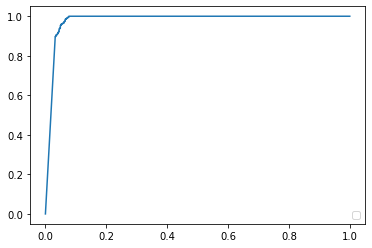

In [33]:
clf = GaussianNB()
clf.fit(xTrain,yTrain)
yPred=clf.predict(xTest)
print("Confusion Matrix - ",confusion_matrix(yTest, yPred))
print("Accuracy using sklearn :",accuracy_score(yTest,yPred))
print("Precision using sklearn:",precision_score(yTest, yPred))
print("Recall using sklearn:",recall_score(yTest, yPred))
print("f1 score using sklearn:",f1_score(yTest, yPred))
y_pred_proba = clf.predict_proba(xTest)[::,1]
fpr, tpr, _ = metrics.roc_curve(yTest,  y_pred_proba,pos_label=1)
plt.plot(tpr,fpr)
plt.legend(loc=4)
plt.show()